# Machine Learning Assignment 2020-2021
**Loukas Papadopoulos**


* This is an assignment that was processed at university's course *Machine Learning*, and it is related with the **Greek Parliament**.
* The pronunciation of the assignment is on the notebook `greek_parliament_proceedings_assignment.ipynb`.



### Imports

Before we begin, we need to import necessary libraries. There are also libraries we will use later, that are propably not pre-downloaded, and you will need to download them.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import re
%matplotlib inline

### Initial cleaning

In [ ]:
gpp = pd.read_csv('https://zenodo.org/record/2587904/files/Greek_Parliament_Proceedings_1989_2019.csv.zip', header=0)

We read the file, right from the website. It contains speeches in the Greek Parliament, from 1989 to 2019.

In [ ]:
gpp.sort_values('sitting_date', ascending=False)

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
1194406,κακλαμανης μιχαηλ νικητας,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,νεα δημοκρατια,προεδρευων,Με τη συναίνεση του Σώματος και ώρα 11.25΄ λύ...
1194358,δελης ιωαννη ιωαννης,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,κομμουνιστικο κομμα ελλαδας,NaN,"Τελειώνω, κύριε Πρόεδρε.Και πού θα τρέχουν αυ..."
1194372,γαβρογλου βασιλειου κωνσταντινος,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,συνασπισμος ριζοσπαστικης αριστερας,"υπουργος παιδειας, ερευνας και θρησκευματων","Κύριε Κατσανιώτη, ξέρετε, πάρα πολλές φορές η..."
1194371,κακλαμανης μιχαηλ νικητας,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,νεα δημοκρατια,προεδρευων,"Κύριε Υπουργέ, έχετε τον λόγο."
1194370,κατσανιωτης ιωαννη ανδρεας,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,νεα δημοκρατια,NaN,Το ΤΕΙ Δυτικής Ελλάδας που σας είπα είναι σε ...
...,...,...,...,...,...,...,...,...
3,NaN,1989-07-03,period 5,session 1,sitting 1,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
2,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ..."
1,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...
4,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...


There are 8 columns:
* `member_name`: the name of the speaker
* `sitting_date`: the day of the speech,
* `parliamentary_period`, `parliamentary_session`, and `parliamentary_sitting`: related with the period of the parliament,
* `political_party`: the party in which the *member_name* belongs,
* `speaker_info`: role of the member of the parliament, and
* `speech`: the speech of the member who talked.

In [ ]:
gpp.dtypes

member_name              object
sitting_date             object
parliamentary_period     object
parliamentary_session    object
parliamentary_sitting    object
political_party          object
speaker_info             object
speech                   object
dtype: object

We will convert `sitting_date` from **object** (string) to **datetime** for easier handling of our dataframe.

In [ ]:
gpp['sitting_date'] = pd.to_datetime(gpp['sitting_date'])

In [ ]:
gpp.isna().sum()

member_name               47289
sitting_date                  0
parliamentary_period          0
parliamentary_session         0
parliamentary_sitting         0
political_party             162
speaker_info             543871
speech                       10
dtype: int64

In [ ]:
gpp['speech'][gpp['member_name'].isna()==True].value_counts().head(20)

 Δεκτό, δεκτό.                 25558
 Μάλιστα, μάλιστα.             11839
 Δεκτή, δεκτή.                  2517
 Μάλιστα, μάλιστα.              1924
 Κρατείται.                      959
Δεκτό, δεκτό.                    473
Μάλιστα, μάλιστα.                240
 Μάλιστα, μάλιστα.\t              93
 Κατά πλειοψηφία.                 83
 Ναι.                             82
Δεκτή, δεκτή.                     78
 Δεκτό, δεκτό. ΔΗΜΗΤΡΙΟΣ Β.       70
Μάλιστα, μάλιστα.                 66
 Δεκτό, δεκτό.ΔΗΜΗΤΡΙΟΣ Ν.        64
 Δεκτό, δεκτό                     51
 Δεκτό, Δεκτό.                    48
 ∆εκτό, δεκτό.ΑΘΑΝΑΣΙΟΣ ∆         47
 Μάλιστα, μάλιστα                 46
 Δεκτός, δεκτός.                  44
 Όχι.                             43
Name: speech, dtype: int64

We see that all values of column `speech` which `member_name` is *NaN*, are sentences consisting of 2 with 3 words. So, even if the member belongs to a political party, the speeches are incapable of providing data for prediction, due to very small **and** pointless -for our assignment's purpose- sentences. As a result, we will drop them (we also drop NaN values from `speech` & `political_party`columns).

In [ ]:
gpp = gpp.dropna(subset=['member_name', 'speech', 'political_party'])
gpp = gpp.reset_index().drop(columns={'index'}) # Clear index

Let's see all other small speeches, with length less than 81 characters.

In [ ]:
print(gpp['speech'][gpp['speech'].str.len() <=50].shape)
gpp['speech'][gpp['speech'].str.len() <=50].head(50)

(433691,)


17                                 Ορίστε, κύριε Αλευρά.
19                       Τον γνωρίζετε καλύτερα από μας.
24                              Και εγώ δεν τις διάβασα.
25                Αν τις έχετε διαβάσει πριν από μένα...
26     Ούτε εγώ τις έχω διαβάσει. Ποια είναι η άποψή ...
27               Δε γνωρίζω. Άμα τις διαβάσω, θα σας πω.
30                Έπρεπε, όμως, εφόσον τις καταθέτετε...
31         Πώς θα προκαταλάβετε τη Βουλή, κύριε Πρόεδρε;
33                                             Παρακαλώ!
36                    Σας είπα ότι δεν τις έχω διαβάσει.
41                                       Ναι.ΣΕΛΙΔΑ 0012
44                                         Ένα αντίτυπο;
50                                                  Ναι.
57                      Κύριε Πρόεδρε, στο 1821 είμαστε;
61                                Εσείς το κάνατε παλιά;
62                                                Πάντα.
63        Παρακαλώ, κύριε Γιαννόπουλε, να μη διακόπτετε!
65                  Παρακαλώ, κ

As we understand, most of the speeches with less than 81 characters, are mainly question/answers to someone else, objections etc. So it don't help us to keep them for our model.

In [ ]:
gpp = gpp[gpp['speech'].str.len() > 50]
gpp.shape

(713379, 8)

Let us see now the role of the speakers.

In [ ]:
gpp['speaker_info'].value_counts().head(20)

προεδρευων                                                     235852
προεδρος                                                        38953
υφυπουργος οικονομικων                                           5067
υπουργος δικαιοσυνης                                             4106
υφυπουργος εθνικης παιδειας και θρησκευματων                     3447
υφυπουργος αναπτυξης                                             2914
υφυπουργος γεωργιας                                              2860
υπουργος γεωργιας                                                2747
υπουργος εσωτερικων                                              2457
υφυπουργος υγειας και κοινωνικης αλληλεγγυης                     2436
υπουργος εμπορικης ναυτιλιας                                     2429
υφυπουργος εσωτερικων, δημοσιας διοικησης και αποκεντρωσης       2416
υφυπουργος οικονομιας και οικονομικων                            2158
υπουργος δημοσιας ταξης                                          2123
υπουργος μεταφορων κ

We also want to delete the rows which `speaker_info` was 'προδευρευων' & 'προεδρος'. This type of speaker does not make speeches of his political party.

In [ ]:
print(gpp.shape)
gpp = gpp[(gpp['speaker_info'] != 'προεδρος') & (gpp['speaker_info'] != 'προεδρευων')]
gpp.shape

(713379, 8)


(438574, 8)

In Greek Parliament, in order someone to speak, needs to ask for permission from the President of the Parliament. There are many questions like these, are needless in our model.

In [ ]:
gpp['speech'][gpp.speaker_info.isna()].value_counts().head(50)

 Κύριε Πρόεδρε, θα ήθελα τον λόγο επί της διαδικασίας.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

We will find them using a Regular Expression, and take those which length of speech was less than 110 characters. We specify 110, in order to avoid dropping speeches that discussed a matter beyond the question (this may happened because of wrong record input, e.g. the speech should be recorder in another row).

In [ ]:
rgx='Κ[υύ]ρ[ιί][εα] Πρόεδρε, ((((θα (ήθελα|μπορούσα))|(μπορώ)|(παρακαλώ)) (να)? ?(μου δώσετε)?)|((έχω )?ζητ(ήσει|ώ))) ?(έχω)? ?τον? λόγο'
mask = gpp['speech'].str.contains(rgx) # mask, to find speeches containing the regular expression
print(gpp['speech'][(mask) & (gpp['speech'].str.len() < 110)].shape) # prints those speeches
gpp['speech'][(mask) & (gpp['speech'].str.len() >= 110)].value_counts().head(50) # prints the speeches containing the regex, but propably discussed a matter

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



(1623,)


 Κύριε Πρόεδρε, ζητώ τον λόγο, διότι από χθες η Δημοκρατική Συμπαράταξη με τον κ. Κωνσταντινόπουλο και σήμερα από το πρωί εγώ, απευθυνόμενος και στον κ. Τσακαλώτο και στον κ. Χουλιαράκη και στην κ. Παπανάτσιου, θέτουμε ένα θέμα που προέκυψε από την κατάργηση όλων των περιορισμών για τα μικρά καζίνο στο κέντρο των πόλεων, σε όλη την Ελλάδα, της 1ης Νοεμβρίου 2016 ΦΕΚ. Το κατέθεσα εδώ. Και είπα, μάλιστα, ότι επειδή δεν είμαστε φιλοκατήγοροι, όπως η σημερινή Συμπολίτευση, να λέμε ότι φταίτε εσείς ή φταίει ο άλλος και ποιος τα πήρε, όπως μας λέγατε, είπαμε ότι η ηγεσία του Υπουργείου προφανώς δεν ξέρει. Κάτω από τα πόδια της, όμως, χορεύουν ποντίκια. Και υπάρχει θέμα διαφθοράς εδώ, όχι ένα θέμα λάθους. Έχει εξαγοραστεί αυτός ο κανονισμός και μου λέτε για το 2011 και για το 2010; Εγώ σας λέω για την 1η Νοεμβρίου του 2016. Και έχει ιστορικό αυτή η υπόθεση.Σας παρακαλώ, φροντίστε να μάθετε τι έχει γίνει και αύριο να δώσετε μια απάντηση, διότι αυτό το θέμα, κυρία Υφυπουργέ, δεν θα κλείσει. Και

Indeed, there are speeches with valuable information beyond asking for permision.

In [ ]:
print(gpp.shape)
gpp = gpp[~((mask) & (gpp['speech'].str.len() < 110))]
gpp.shape

(438574, 8)


(436951, 8)

#### **Total speeches per party**

Let's visualize now, the total speeches per party. We will keep only those with more than 2000 speeches.

In [ ]:
total_speeches = gpp['political_party'].value_counts().reset_index().rename(columns={"index":"party", "political_party":"speeches"})
total_speeches = total_speeches[total_speeches.speeches > 2000]
total_speeches

,party,speeches
0,πανελληνιο σοσιαλιστικο κινημα,151707
1,νεα δημοκρατια,149258
2,συνασπισμος ριζοσπαστικης αριστερας,42913
3,κομμουνιστικο κομμα ελλαδας,26682
4,συνασπισμος της αριστερας των κινηματων και τη...,16062
5,ανεξαρτητοι (εκτος κομματος),11874
6,λαικος ορθοδοξος συναγερμος,9669
7,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστι...,6404
8,λαικος συνδεσος - χρυση αυγη,5196
9,δημοκρατικο κοινωνικο κινημα,4100


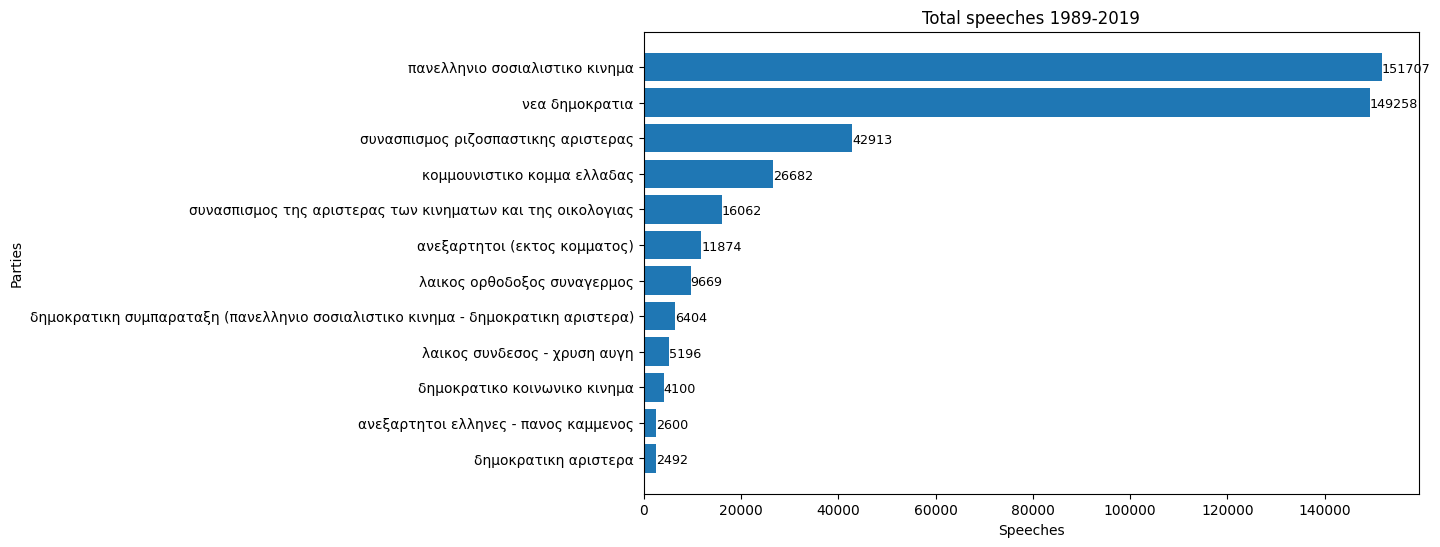

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 6))

pp_speeches = total_speeches['speeches'].tolist()

people = total_speeches['party'].tolist()
y_pos = np.arange(len(people))
num = pp_speeches

ax.barh(y_pos, num, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Speeches')
ax.set_ylabel('Parties')
ax.set_title('Total speeches 1989-2019')

for i in range(len(pp_speeches)):
  ax.text(pp_speeches[i], i + 0.05, pp_speeches[i], verticalalignment="center", color='black', size=0.4*23)

plt.show()

It seems that in all these years, 'Πανελληνιο Σοσιαλιστικο Κινημα' (ΠΑΣΟΚ) and 'Νεα Δημοκρατια' (ΝΔ), were participating a lot in the speeches of the parliament. The political party 'Συνασπισμος Ριζοσπαστικης Αριστερας' (ΣΥΡΙΖΑ) is 3rd. Propably because from 2015 till 2019, it became for the first time, the leading political party, with Alexi Tsipra as the Prime Minister of Greece.

## Searching for our subset

Before proceeding to editing the free text, we want to choose a subset of our dataframe (more specifically, consecutive *Parliamentary Terms*), which will have enough data (speeches) for training and valid prediction.

<small>'Parliament Term' is the interval between two elections.</small>

### Web scrapping
the Prime Ministers and the datetimes they governed

We want to find the timeline of the Prime Ministers that governed Greece, from were our data begin (1989). We find these timelines from here: https://gslegal.gov.gr/?page_id=776&sort=time

In [ ]:
import requests
import re
from bs4 import BeautifulSoup

r = requests.get("https://gslegal.gov.gr/?page_id=776&sort=time")

In [ ]:
html = r.content
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
govs = [] # govs stands for 'governments'
dates = soup.find_all("tr")
for td in dates:
    govs.append([td.get_text()])

Our data start from 3/7/1989, so the closest date from `govs` list, is on the 107th line, from 2/7/1989.

In [ ]:
govs = govs[107:]
govs

[['\n107.\nΤΖΑΝΝΕΤΑΚΗ ΤΖΑΝΝΗ\n2.7.1989\n12.10.1989\n'],
 ['\n108.\nΓΡΙΒΑ ΙΩΑΝΝΗ\n12.10.1989\n23.11.1989\n'],
 ['\n109.\nΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ\n23.11.1989\n11.4.1990\n'],
 ['\n110.\nΜΗΤΣΟΤΑΚΗ ΚΩΝΣΤΑΝΤΙΝΟΥ\n11.4.1990\n13.10.1993\n'],
 ['\n111.\nΠΑΠΑΝΔΡΕΟΥ ΑΝΔΡΕΑ\n13.10.1993\n22.1.1996\n'],
 ['\n112.\nΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ\n22.1.1996\n25.9.1996\n'],
 ['\n113.\nΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ\n25.9.1996\n13.4.2000\n'],
 ['\n114.\nΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ\n13.4.2000\n10.3.2004\n'],
 ['\n115.\nΚΑΡΑΜΑΝΛΗ Α. ΚΩΝΣΤΑΝΤΙΝΟΥ\n10.03.2004\n19.9.2007\n'],
 ['\n116.\nΚΑΡΑΜΑΝΛΗ Α. ΚΩΝΣΤΑΝΤΙΝΟΥ\n19.9.2007\n7.10.2009\n'],
 ['\n117.\nΠΑΠΑΝΔΡΕΟΥ Α. ΓΕΩΡΓΙΟΥ\n6.10.2009\n11.11.2011\n'],
 ['\n118.\nΠΑΠΑΔΗΜΟΥ ΛΟΥΚΑ Δ.\n11.11.2011\n17.05.2012\n'],
 ['\n119.\nΠΙΚΡΑΜΜΕΝΟΥ ΠΑΝΑΓΙΩΤΗ ΟΘ. (ΥΠΗΡΕΣΙΑΚΗ)\n17/05/2012\n21/06/2012\n'],
 ['\n120.\nΣΑΜΑΡΑ Κ. ΑΝΤΩΝΙΟΥ\n21.06.2012\n26.01.2015\n'],
 ['\n121.\nΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ\n26.01.2015\n27.08.2015\n'],
 ['\n122.\nΘΑΝΟΥ-ΧΡΙΣΤΟΦΙΛΟΥ ΒΑΣΙΛΙΚΗΣ (ΥΠΗΡΕΣΙΑΚΗ)\n27.08.2015\n21.09.2015\n'],
 ['\n123.\nΤΣΙΠ

We keep only the names of the Prime Ministers, the date they started and the day they ended governin, using Regular Expressions, and pass them to a list.

In [ ]:
governed = []
for i in govs:
  x = [x.group() for x in re.finditer( r'([Α-Ω][Α-Ω. \-]{1,50}(\([Α-Ω]{1,20}\))?)|(\d{1,2}.\d{1,2}.\d{4})', i[0])]
  governed.append(x)

In [ ]:
governed

[['ΤΖΑΝΝΕΤΑΚΗ ΤΖΑΝΝΗ', '2.7.1989', '12.10.1989'],
 ['ΓΡΙΒΑ ΙΩΑΝΝΗ', '12.10.1989', '23.11.1989'],
 ['ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ', '23.11.1989', '11.4.1990'],
 ['ΜΗΤΣΟΤΑΚΗ ΚΩΝΣΤΑΝΤΙΝΟΥ', '11.4.1990', '13.10.1993'],
 ['ΠΑΠΑΝΔΡΕΟΥ ΑΝΔΡΕΑ', '13.10.1993', '22.1.1996'],
 ['ΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ', '22.1.1996', '25.9.1996'],
 ['ΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ', '25.9.1996', '13.4.2000'],
 ['ΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ', '13.4.2000', '10.3.2004'],
 ['ΚΑΡΑΜΑΝΛΗ Α. ΚΩΝΣΤΑΝΤΙΝΟΥ', '10.03.2004', '19.9.2007'],
 ['ΚΑΡΑΜΑΝΛΗ Α. ΚΩΝΣΤΑΝΤΙΝΟΥ', '19.9.2007', '7.10.2009'],
 ['ΠΑΠΑΝΔΡΕΟΥ Α. ΓΕΩΡΓΙΟΥ', '6.10.2009', '11.11.2011'],
 ['ΠΑΠΑΔΗΜΟΥ ΛΟΥΚΑ Δ.', '11.11.2011', '17.05.2012'],
 ['ΠΙΚΡΑΜΜΕΝΟΥ ΠΑΝΑΓΙΩΤΗ ΟΘ. (ΥΠΗΡΕΣΙΑΚΗ)', '17/05/2012', '21/06/2012'],
 ['ΣΑΜΑΡΑ Κ. ΑΝΤΩΝΙΟΥ', '21.06.2012', '26.01.2015'],
 ['ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ', '26.01.2015', '27.08.2015'],
 ['ΘΑΝΟΥ-ΧΡΙΣΤΟΦΙΛΟΥ ΒΑΣΙΛΙΚΗΣ (ΥΠΗΡΕΣΙΑΚΗ)', '27.08.2015', '21.09.2015'],
 ['ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ', '21.09.2015', '8.7.2019'],
 ['ΜΗΤΣΟΤΑΚΗ ΚΥΡΙΑΚΟΥ', '8.7.2019', 'ΣΗΜΕΡΑ']]

There are some dates that can be merged, because the names of the governors are the same. There are also some prime ministers who governed temporary at the time before a new had been elected. We will drop them.

In [ ]:
# First remove temporary governors
governed.remove(['ΠΙΚΡΑΜΜΕΝΟΥ ΠΑΝΑΓΙΩΤΗ ΟΘ. (ΥΠΗΡΕΣΙΑΚΗ)', '17/05/2012', '21/06/2012'])
governed.remove(['ΘΑΝΟΥ-ΧΡΙΣΤΟΦΙΛΟΥ ΒΑΣΙΛΙΚΗΣ (ΥΠΗΡΕΣΙΑΚΗ)', '27.08.2015', '21.09.2015'])

# Secondly, remove duplicate names
for i in range(1, len(governed)):
  if governed[i-1][0]==governed[i][0]:
    governed[i][1] = governed[i-1][1] # place starting date to the list of governor we will keep
    governed[i-1] = False

governed = list(filter(None, governed)) # Drop false elements from list

governed

[['ΤΖΑΝΝΕΤΑΚΗ ΤΖΑΝΝΗ', '2.7.1989', '12.10.1989'],
 ['ΓΡΙΒΑ ΙΩΑΝΝΗ', '12.10.1989', '23.11.1989'],
 ['ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ', '23.11.1989', '11.4.1990'],
 ['ΜΗΤΣΟΤΑΚΗ ΚΩΝΣΤΑΝΤΙΝΟΥ', '11.4.1990', '13.10.1993'],
 ['ΠΑΠΑΝΔΡΕΟΥ ΑΝΔΡΕΑ', '13.10.1993', '22.1.1996'],
 ['ΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ', '22.1.1996', '10.3.2004'],
 ['ΚΑΡΑΜΑΝΛΗ Α. ΚΩΝΣΤΑΝΤΙΝΟΥ', '10.03.2004', '7.10.2009'],
 ['ΠΑΠΑΝΔΡΕΟΥ Α. ΓΕΩΡΓΙΟΥ', '6.10.2009', '11.11.2011'],
 ['ΠΑΠΑΔΗΜΟΥ ΛΟΥΚΑ Δ.', '11.11.2011', '17.05.2012'],
 ['ΣΑΜΑΡΑ Κ. ΑΝΤΩΝΙΟΥ', '21.06.2012', '26.01.2015'],
 ['ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ', '26.01.2015', '8.7.2019'],
 ['ΜΗΤΣΟΤΑΚΗ ΚΥΡΙΑΚΟΥ', '8.7.2019', 'ΣΗΜΕΡΑ']]

### Picking subset based on date.

In [ ]:
from pandas import DataFrame
governments = DataFrame (governed, columns=['Governor','Start','End'])
governments['End'][governments['Governor']=='ΜΗΤΣΟΤΑΚΗ ΚΥΡΙΑΚΟΥ']= '9.7.2019'
governments

,Governor,Start,End
0,ΤΖΑΝΝΕΤΑΚΗ ΤΖΑΝΝΗ,2.7.1989,12.10.1989
1,ΓΡΙΒΑ ΙΩΑΝΝΗ,12.10.1989,23.11.1989
2,ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ,23.11.1989,11.4.1990
3,ΜΗΤΣΟΤΑΚΗ ΚΩΝΣΤΑΝΤΙΝΟΥ,11.4.1990,13.10.1993
4,ΠΑΠΑΝΔΡΕΟΥ ΑΝΔΡΕΑ,13.10.1993,22.1.1996
5,ΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ,22.1.1996,10.3.2004
6,ΚΑΡΑΜΑΝΛΗ Α. ΚΩΝΣΤΑΝΤΙΝΟΥ,10.03.2004,7.10.2009
7,ΠΑΠΑΝΔΡΕΟΥ Α. ΓΕΩΡΓΙΟΥ,6.10.2009,11.11.2011
8,ΠΑΠΑΔΗΜΟΥ ΛΟΥΚΑ Δ.,11.11.2011,17.05.2012
9,ΣΑΜΑΡΑ Κ. ΑΝΤΩΝΙΟΥ,21.06.2012,26.01.2015


In [ ]:
governments['Start'] = pd.to_datetime(governments['Start'], dayfirst=True)
governments['End'] = pd.to_datetime(governments['End'], dayfirst=True)
governments

,Governor,Start,End
0,ΤΖΑΝΝΕΤΑΚΗ ΤΖΑΝΝΗ,1989-07-02,1989-10-12
1,ΓΡΙΒΑ ΙΩΑΝΝΗ,1989-10-12,1989-11-23
2,ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ,1989-11-23,1990-04-11
3,ΜΗΤΣΟΤΑΚΗ ΚΩΝΣΤΑΝΤΙΝΟΥ,1990-04-11,1993-10-13
4,ΠΑΠΑΝΔΡΕΟΥ ΑΝΔΡΕΑ,1993-10-13,1996-01-22
5,ΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ,1996-01-22,2004-03-10
6,ΚΑΡΑΜΑΝΛΗ Α. ΚΩΝΣΤΑΝΤΙΝΟΥ,2004-03-10,2009-10-07
7,ΠΑΠΑΝΔΡΕΟΥ Α. ΓΕΩΡΓΙΟΥ,2009-10-06,2011-11-11
8,ΠΑΠΑΔΗΜΟΥ ΛΟΥΚΑ Δ.,2011-11-11,2012-05-17
9,ΣΑΜΑΡΑ Κ. ΑΝΤΩΝΙΟΥ,2012-06-21,2015-01-26


In [ ]:
gpp['governor']=''
gpp['end']=''
for index,row in governments.iterrows():
  # print(index)
  gpp['governor'][(governments.at[index, 'Start']<=gpp['sitting_date']) & (gpp['sitting_date']<governments.at[index, 'End'])] = governments.at[index, 'Governor']
  gpp['end'][(governments.at[index, 'Start']<=gpp['sitting_date']) & (gpp['sitting_date']<governments.at[index, 'End'])] = governments.at[index, 'End']

gpp['end'] = pd.to_datetime(gpp['end'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
gpp.tail(5)

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech,governor,end
1147055,γαβρογλου βασιλειου κωνσταντινος,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,συνασπισμος ριζοσπαστικης αριστερας,"υπουργος παιδειας, ερευνας και θρησκευματων",Το Στερεάς Ελλάδας. Αυτό δεν λέτε τώρα; Αντί ...,ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08
1147057,γαβρογλου βασιλειου κωνσταντινος,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,συνασπισμος ριζοσπαστικης αριστερας,"υπουργος παιδειας, ερευνας και θρησκευματων",Καταλαβαίνετε τι λέτε τώρα; Αυτό είναι το πρώ...,ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08
1147059,συντυχακης δανιηλ εμμανουηλ,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,κομμουνιστικο κομμα ελλαδας,NaN,"Ευχαριστώ, κύριε Πρόεδρε.Κύριε Υπουργέ, έγινα...",ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08
1147061,συντυχακης δανιηλ εμμανουηλ,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,κομμουνιστικο κομμα ελλαδας,NaN,"Ολοκλήρωσα, κύριε Πρόεδρε. Αντιλαμβάνεστε ότι...",ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08
1147066,συντυχακης δανιηλ εμμανουηλ,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,κομμουνιστικο κομμα ελλαδας,NaN,"Κύριε Πρόεδρε, οι καταστροφές προφανώς δεν ήτ...",ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08


In [ ]:
gpp['speech'].groupby(gpp['governor']).count()

governor
                                 13
ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ               2733
ΚΑΡΑΜΑΝΛΗ Α. ΚΩΝΣΤΑΝΤΙΝΟΥ     86545
ΜΗΤΣΟΤΑΚΗ ΚΩΝΣΤΑΝΤΙΝΟΥ        73284
ΠΑΠΑΔΗΜΟΥ ΛΟΥΚΑ Δ.             8511
ΠΑΠΑΝΔΡΕΟΥ Α. ΓΕΩΡΓΙΟΥ        35698
ΠΑΠΑΝΔΡΕΟΥ ΑΝΔΡΕΑ             16443
ΣΑΜΑΡΑ Κ. ΑΝΤΩΝΙΟΥ            41999
ΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ          108208
ΤΖΑΝΝΕΤΑΚΗ ΤΖΑΝΝΗ              4149
ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ             59368
Name: speech, dtype: int64

These are the speeches per governor. It seems there are some rows with *null* governor. We will drop them.

In [ ]:
gpp = gpp[gpp['governor'] != '']

In [ ]:
gpp.groupby(['governor', 'end'])['speech'].count().reset_index().sort_values('end')

,governor,end,speech
8,ΤΖΑΝΝΕΤΑΚΗ ΤΖΑΝΝΗ,1989-10-12,4149
0,ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ,1990-04-11,2733
2,ΜΗΤΣΟΤΑΚΗ ΚΩΝΣΤΑΝΤΙΝΟΥ,1993-10-13,73284
5,ΠΑΠΑΝΔΡΕΟΥ ΑΝΔΡΕΑ,1996-01-22,16443
7,ΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ,2004-03-10,108208
1,ΚΑΡΑΜΑΝΛΗ Α. ΚΩΝΣΤΑΝΤΙΝΟΥ,2009-10-07,86545
4,ΠΑΠΑΝΔΡΕΟΥ Α. ΓΕΩΡΓΙΟΥ,2011-11-11,35698
3,ΠΑΠΑΔΗΜΟΥ ΛΟΥΚΑ Δ.,2012-05-17,8511
6,ΣΑΜΑΡΑ Κ. ΑΝΤΩΝΙΟΥ,2015-01-26,41999
9,ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08,59368


Let's visualize that.

In [ ]:
tspg = gpp.groupby(['governor', 'end'])['speech'].count().reset_index().sort_values('end')
tspg

,governor,end,speech
8,ΤΖΑΝΝΕΤΑΚΗ ΤΖΑΝΝΗ,1989-10-12,4149
0,ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ,1990-04-11,2733
2,ΜΗΤΣΟΤΑΚΗ ΚΩΝΣΤΑΝΤΙΝΟΥ,1993-10-13,73284
5,ΠΑΠΑΝΔΡΕΟΥ ΑΝΔΡΕΑ,1996-01-22,16443
7,ΣΗΜΙΤΗ ΚΩΝΣΤΑΝΤΙΝΟΥ,2004-03-10,108208
1,ΚΑΡΑΜΑΝΛΗ Α. ΚΩΝΣΤΑΝΤΙΝΟΥ,2009-10-07,86545
4,ΠΑΠΑΝΔΡΕΟΥ Α. ΓΕΩΡΓΙΟΥ,2011-11-11,35698
3,ΠΑΠΑΔΗΜΟΥ ΛΟΥΚΑ Δ.,2012-05-17,8511
6,ΣΑΜΑΡΑ Κ. ΑΝΤΩΝΙΟΥ,2015-01-26,41999
9,ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08,59368


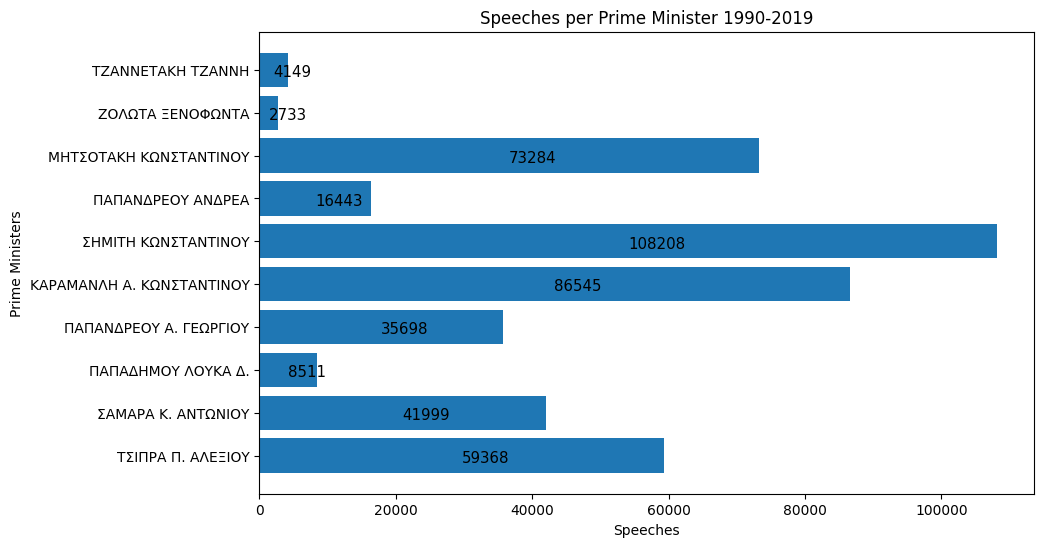

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 6))

pg_speeches = tspg.speech.tolist()

governors = tspg['governor'].tolist()
y_pos = np.arange(len(governors))
num = pg_speeches

ax.barh(y_pos, pg_speeches, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(governors)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Speeches')
ax.set_ylabel('Prime Ministers')
ax.set_title('Speeches per Prime Minister 1990-2019')

for i in range(len(governors)):
  ax.text(pg_speeches[i]/2-1, i + 0.05, pg_speeches[i], verticalalignment="center", color='black', size=0.4*27)

plt.show()

We see that most of the speeches happened during the governance of Simiti Konstandinou (*ΠΑΣΟΚ* - *PASOK*), and then of Karamanli Konstandinou (*ΝΔ* - *New Democracy*). It makes sense, because the latter governed for 8 years, and the former for 5 and a half years.

In [ ]:
gpp['political_party'][(gpp['sitting_date']>=pd.to_datetime('1990-01-01'))].value_counts()

πανελληνιο σοσιαλιστικο κινημα                                                     149676
νεα δημοκρατια                                                                     147431
συνασπισμος ριζοσπαστικης αριστερας                                                 42911
κομμουνιστικο κομμα ελλαδας                                                         26631
συνασπισμος της αριστερας των κινηματων και της οικολογιας                          15515
ανεξαρτητοι (εκτος κομματος)                                                        11874
λαικος ορθοδοξος συναγερμος                                                          9669
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)      6404
λαικος συνδεσος - χρυση αυγη                                                         5196
δημοκρατικο κοινωνικο κινημα                                                         4100
ανεξαρτητοι ελληνες - πανος καμμενος                                                 2600
δημοκρατικ

We will take all speeches from 1990 and after.

In [ ]:
print(gpp.shape)
gpp = gpp[gpp['sitting_date']>=pd.to_datetime('1990-01-1')]
gpp.shape

(436938, 10)


(432351, 10)

### Droping parties.

In [ ]:
gpp['political_party'].value_counts()

πανελληνιο σοσιαλιστικο κινημα                                                     149676
νεα δημοκρατια                                                                     147431
συνασπισμος ριζοσπαστικης αριστερας                                                 42911
κομμουνιστικο κομμα ελλαδας                                                         26631
συνασπισμος της αριστερας των κινηματων και της οικολογιας                          15515
ανεξαρτητοι (εκτος κομματος)                                                        11874
λαικος ορθοδοξος συναγερμος                                                          9669
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)      6404
λαικος συνδεσος - χρυση αυγη                                                         5196
δημοκρατικο κοινωνικο κινημα                                                         4100
ανεξαρτητοι ελληνες - πανος καμμενος                                                 2600
δημοκρατικ

* The party "ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια" belongs to "ανεξαρτητοι ελληνες - πανος καμμενος", so they must be merged,
* "ανεξαρτητοι (εκτος κομματος)" was a independent party of members from, each of different party, created at 23 November 2013, and stoped at 2015. We do not need it.
* "συνασπισμος της αριστερας των κινηματων και της οικολογιας", contributed a lot in the formation of "συνασπισμος ριζοσπαστικης αριστερας". At 2013, the former stoped operating because the latter would become a political party. So it would not help keeping it.
* There are lots of parties with few speeches. We will keep only those close to 10,000, and more.

In [ ]:
gpp['political_party'][gpp['political_party']=='ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια'] = 'ανεξαρτητοι ελληνες - πανος καμμενος'
gpp = gpp[(gpp['political_party'] != 'συνασπισμος της αριστερας των κινηματων και της οικολογιας') & (gpp['political_party'] != 'ανεξαρτητοι (εκτος κομματος)')]
gpp['political_party'].value_counts()

πανελληνιο σοσιαλιστικο κινημα                                                     149676
νεα δημοκρατια                                                                     147431
συνασπισμος ριζοσπαστικης αριστερας                                                 42911
κομμουνιστικο κομμα ελλαδας                                                         26631
λαικος ορθοδοξος συναγερμος                                                          9669
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)      6404
λαικος συνδεσος - χρυση αυγη                                                         5196
ανεξαρτητοι ελληνες - πανος καμμενος                                                 4276
δημοκρατικο κοινωνικο κινημα                                                         4100
δημοκρατικη αριστερα                                                                 2492
ενωση κεντρωων                                                                       1737
το ποταμι 

In [ ]:
# tspp stands for 'total_speeches_per_party'
tspp = gpp['political_party'].value_counts().reset_index().rename(columns={"index":"party", "political_party":"speeches"})
tspp = tspp[tspp.speeches > 9500] # We put 9500 to catch the parties close to 10000.
tspp

,party,speeches
0,πανελληνιο σοσιαλιστικο κινημα,149676
1,νεα δημοκρατια,147431
2,συνασπισμος ριζοσπαστικης αριστερας,42911
3,κομμουνιστικο κομμα ελλαδας,26631
4,λαικος ορθοδοξος συναγερμος,9669


In [ ]:
print(gpp.shape)
party_names = tspp['party'].unique().tolist()
gpp = gpp[(gpp['political_party'].isin(party_names))==True ]
gpp.shape

(404962, 10)


(376318, 10)

In [ ]:
gpp

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech,governor,end
10159,αλευρας νικολαου ιωαννης,1990-01-09,period 6,session 1,sitting 14,πανελληνιο σοσιαλιστικο κινημα,NaN,"Δεν έχουμε αντίρρηση, αλλά να συνεννοηθούμε. ...",ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ,1990-04-11
10162,μπουλουκος γεωργιου αριστοδημος,1990-01-09,period 6,session 1,sitting 14,νεα δημοκρατια,NaN,"Κύριε Πρόεδρε, κύριοι συνάδελφοι, η κοσμογονί...",ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ,1990-04-11
10167,κοντογιαννοπουλος νικολαου βασιλειος,1990-01-09,period 6,session 1,sitting 14,νεα δημοκρατια,αναπληρωτης υπουργος παιδειας και θρησκευματων,"Κυρίες και κύριοι συνάδελφοι, είναι γεγονός ό...",ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ,1990-04-11
10169,μπουλουκος γεωργιου αριστοδημος,1990-01-09,period 6,session 1,sitting 14,νεα δημοκρατια,NaN,"Κύριε Πρόεδρε, πιστεύω ότι στην εξέταση των α...",ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ,1990-04-11
10172,κοντογιαννοπουλος νικολαου βασιλειος,1990-01-09,period 6,session 1,sitting 14,νεα δημοκρατια,αναπληρωτης υπουργος εθνικης παιδειας και θρησ...,"Δεν νομίζω κατ` αρχήν, κύριε συνάδελφε, ότι ε...",ΖΟΛΩΤΑ ΞΕΝΟΦΩΝΤΑ,1990-04-11
...,...,...,...,...,...,...,...,...,...,...
1147055,γαβρογλου βασιλειου κωνσταντινος,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,συνασπισμος ριζοσπαστικης αριστερας,"υπουργος παιδειας, ερευνας και θρησκευματων",Το Στερεάς Ελλάδας. Αυτό δεν λέτε τώρα; Αντί ...,ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08
1147057,γαβρογλου βασιλειου κωνσταντινος,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,συνασπισμος ριζοσπαστικης αριστερας,"υπουργος παιδειας, ερευνας και θρησκευματων",Καταλαβαίνετε τι λέτε τώρα; Αυτό είναι το πρώ...,ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08
1147059,συντυχακης δανιηλ εμμανουηλ,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,κομμουνιστικο κομμα ελλαδας,NaN,"Ευχαριστώ, κύριε Πρόεδρε.Κύριε Υπουργέ, έγινα...",ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08
1147061,συντυχακης δανιηλ εμμανουηλ,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,κομμουνιστικο κομμα ελλαδας,NaN,"Ολοκλήρωσα, κύριε Πρόεδρε. Αντιλαμβάνεστε ότι...",ΤΣΙΠΡΑ Π. ΑΛΕΞΙΟΥ,2019-07-08


## Natural Language Processing

In [ ]:
df_data = gpp

##### Mapping

There are 6 different labels for classification.

In [ ]:
map_party_names = {
    "πανελληνιο σοσιαλιστικο κινημα":'ΠΑΣΟΚ',
    "νεα δημοκρατια":'ΝΔ',
    "κομμουνιστικο κομμα ελλαδας":'ΚΚΕ',
    "συνασπισμος ριζοσπαστικης αριστερας":'ΣΥΡΙΖΑ',
    "λαικος ορθοδοξος συναγερμος":'ΛΑΟΣ'
}
map_party_id = {
    "ΠΑΣΟΚ":0,
    "ΝΔ":1,
    "ΚΚΕ":2,
    "ΣΥΡΙΖΑ":3,
    "ΛΑΟΣ":4
}
df_data['political_party'] = df_data['political_party'].map(map_party_names)
df_data['target'] = df_data['political_party'].map(map_party_id)
df_data['target'] = df_data['target'].fillna({'target':0})
df_data['target'] = df_data['target'].astype(int) 
# df_data

In [ ]:
df_data = df_data[['political_party', 'speech', 'target']]
# df_data

In [ ]:
df_data.sample(5)

,political_party,speech,target
849631,ΣΥΡΙΖΑ,"Ευχαριστώ, κυρία Πρόεδρε.Κύριε Υπουργέ, το 20...",3
375760,ΝΔ,"Εσείς μπορεί να λέτε ό,τι θέλετε. Εγώ πιστεύω...",1
959638,ΚΚΕ,"Θα μιλήσω, κατ’ αρχάς, για το διαδικαστικό. Π...",2
728204,ΠΑΣΟΚ,"Κύριε Πρόεδρε, ξεκινήσατε τη διαδικασία του λ...",0
275142,ΚΚΕ,"Κύριε Πρόεδρε, αυτό που κράτησα από την τοποθ...",2


#### Deeper cleaning

##### **Intro**

The cleaning we did earlier was not enough. So far, we have dropped lines based on certain conditions. In order to fasten up our model, and extract better predictions, we need to go deeper, into the syntax and maybe grammar of the speeches, and clean in there.

In [ ]:
df_data['speech'].head(20)

10159     Δεν έχουμε αντίρρηση, αλλά να συνεννοηθούμε. ...
10162     Κύριε Πρόεδρε, κύριοι συνάδελφοι, η κοσμογονί...
10167     Κυρίες και κύριοι συνάδελφοι, είναι γεγονός ό...
10169     Κύριε Πρόεδρε, πιστεύω ότι στην εξέταση των α...
10172     Δεν νομίζω κατ` αρχήν, κύριε συνάδελφε, ότι ε...
10174     Κύριε Πρόεδρε, κυρίες και κύριοι συνάδελφοι, ...
10175     Μια παρατήρηση επί του Κανονισμού. Όπως θα γν...
10176     Δεν ζήτησα τον Υπουργό των Οικονομικών, αλλά ...
10177     Κυρίες και κύριοι συνάδελφοι, ένας ήπιος χαρα...
10179     Μακάρι. Μακάρι να ανακαλέσετε τον εαυτό σας. ...
10181     Δεν ξέρω ποιος σας ακούει, κύριε Γιαννόπουλε....
10183     Και ξέρετε ποιο είναι το χειρότερο; Ότι μας λ...
10185     Εσάς ελέγχουμε, για να σας απαντήσω, γιατί φτ...
10186     Ποιον ελέγχετε, κύριε συνάδελφε; Την Κυβέρνησ...
10187     Εσάς ελέγχουμε κύριε συνάδελφε. Και σας απάντ...
10189     Ο Λαός έχει μάτια, βλέπει και κρίνει. Εσείς φ...
10191     Δεν θα απαντήσετε σε μένα, κύριε Γεννηματά. Θ.

In [ ]:
# !pip install urllib
# import urllib.request
# stop_words = []
# for line in urllib.request.urlopen('https://raw.githubusercontent.com/pmav99/greek_stopwords/master/tonoi.txt'):
#   stop_words.append(line.decode('utf-8'))
# stop_words = [s.replace('\n', '') for s in stop_words]
# s_w=[]
# for i in stop_words:
#   if (i[-1] == 'σ'):
#     i = i[:-1]+'ς'
#   s_w.append(i)
# print(s_w)
# del stop_words

We will create a function that for each speech, does a clean-up. The final form of speech will have less useless words, and capture less storage.

##### **STOP-WORDS**

First we take the **stop_words** provided from spacy: https://github.com/explosion/spaCy/blob/master/spacy/lang/el/stop_words.py

In [ ]:
STOP_WORDS = set(
    """
αδιάκοπα αι ακόμα ακόμη ακριβώς άλλα αλλά αλλαχού άλλες άλλη άλλην
άλλης αλλιώς αλλιώτικα άλλο άλλοι αλλοιώς αλλοιώτικα άλλον άλλος άλλοτε αλλού
άλλους άλλων άμα άμεσα αμέσως αν ανά ανάμεσα αναμεταξύ άνευ αντί αντίπερα αντίς
άνω ανωτέρω άξαφνα απ απέναντι από απόψε άρα άραγε αρκετά αρκετές
αρχικά ας αύριο αυτά αυτές αυτή αυτήν αυτής αυτό αυτοί αυτόν αυτός αυτού αυτούς
αυτών αφότου αφού
βέβαια βεβαιότατα
γι για γιατί γρήγορα γύρω
δα δε δείνα δεν δεξιά δήθεν δηλαδή δι δια διαρκώς δικά δικό δικοί δικός δικού
δικούς διόλου δίπλα δίχως
εάν εαυτό εαυτόν εαυτού εαυτούς εαυτών έγκαιρα εγκαίρως εγώ εδώ ειδεμή είθε είμαι
είμαστε είναι εις είσαι είσαστε είστε είτε είχα είχαμε είχαν είχατε είχε είχες έκαστα
έκαστες έκαστη έκαστην έκαστης έκαστο έκαστοι έκαστον έκαστος εκάστου εκάστους εκάστων
εκεί εκείνα εκείνες εκείνη εκείνην εκείνης εκείνο εκείνοι εκείνον εκείνος εκείνου
εκείνους εκείνων εκτός εμάς εμείς εμένα εμπρός εν ένα έναν ένας ενός εντελώς εντός
εναντίον  εξής  εξαιτίας  επιπλέον επόμενη εντωμεταξύ ενώ εξ έξαφνα εξήσ εξίσου έξω επάνω
επειδή έπειτα επί επίσης επομένως εσάς εσείς εσένα έστω εσύ ετέρα ετέραι ετέρας έτερες
έτερη έτερης έτερο έτεροι έτερον έτερος ετέρου έτερους ετέρων ετούτα ετούτες ετούτη ετούτην
ετούτης ετούτο ετούτοι ετούτον ετούτος ετούτου ετούτους ετούτων έτσι εύγε ευθύς ευτυχώς εφεξής
έχει έχεις έχετε έχομε έχουμε έχουν εχτές έχω έως έγιναν  έγινε  έκανε  έξι  έχοντας
η ήδη ήμασταν ήμαστε ήμουν ήσασταν ήσαστε ήσουν ήταν ήτανε ήτοι ήττον
θα
ι ιδία ίδια ίδιαν ιδίας ίδιες ίδιο ίδιοι ίδιον ίδιοσ ίδιος ιδίου ίδιους ίδιων ιδίως ιι ιιι
ίσαμε ίσια ίσως
κάθε καθεμία καθεμίας καθένα καθένας καθενός καθετί καθόλου καθώς και κακά κακώς καλά
καλώς καμία καμίαν καμίας κάμποσα κάμποσες κάμποση κάμποσην κάμποσης κάμποσο κάμποσοι
κάμποσον κάμποσος κάμποσου κάμποσους κάμποσων κανείς κάνεν κανένα κανέναν κανένας
κανενός κάποια κάποιαν κάποιας κάποιες κάποιο κάποιοι κάποιον κάποιος κάποιου κάποιους
κάποιων κάποτε κάπου κάπως κατ κατά κάτι κατιτί κατόπιν κάτω κιόλας κλπ κοντά κτλ κυρίως
λιγάκι λίγο λιγότερο λόγω λοιπά λοιπόν
μα μαζί μακάρι μακρυά μάλιστα μάλλον μας με μεθαύριο μείον μέλει μέλλεται μεμιάς μεν
μερικά μερικές μερικοί μερικούς μερικών μέσα μετ μετά μεταξύ μέχρι μη μήδε μην μήπως
μήτε μια μιαν μιας μόλις μολονότι μονάχα μόνες μόνη μόνην μόνης μόνο μόνοι μονομιάς
μόνος μόνου μόνους μόνων μου μπορεί μπορούν μπρος μέσω  μία  μεσώ
να ναι νωρίς
ξανά ξαφνικά
ο οι όλα όλες όλη όλην όλης όλο ολόγυρα όλοι όλον ολονέν όλος ολότελα όλου όλους όλων
όλως ολωσδιόλου όμως όποια οποιαδήποτε οποίαν οποιανδήποτε οποίας οποίος οποιασδήποτε οποιδήποτε
όποιες οποιεσδήποτε όποιο οποιοδηήποτε όποιοι όποιον οποιονδήποτε όποιος οποιοσδήποτε
οποίου οποιουδήποτε οποίους οποιουσδήποτε οποίων οποιωνδήποτε όποτε οποτεδήποτε όπου
οπουδήποτε όπως ορισμένα ορισμένες ορισμένων ορισμένως όσα οσαδήποτε όσες οσεσδήποτε
όση οσηδήποτε όσην οσηνδήποτε όσης οσησδήποτε όσο οσοδήποτε όσοι οσοιδήποτε όσον οσονδήποτε
όσος οσοσδήποτε όσου οσουδήποτε όσους οσουσδήποτε όσων οσωνδήποτε όταν ότι οτιδήποτε
ότου ου ουδέ ούτε όχι οποία  οποίες  οποίο  οποίοι  οπότε  ος
πάνω  παρά  περί  πολλά  πολλές  πολλοί  πολλούς  που  πρώτα  πρώτες  πρώτη  πρώτο  πρώτος  πως
πάλι πάντα πάντοτε παντού πάντως πάρα πέρα πέρι περίπου περισσότερο πέρσι πέρυσι πια πιθανόν
πιο πίσω πλάι πλέον πλην ποιά ποιάν ποιάς ποιές ποιό ποιοί ποιόν ποιός ποιού ποιούς
ποιών πολύ πόσες πόση πόσην πόσης πόσοι πόσος πόσους πότε ποτέ πού πούθε πουθενά πρέπει
πριν προ προκειμένου πρόκειται πρόπερσι προς προτού προχθές προχτές πρωτύτερα πώς
σαν σας σε σεις σου στα στη στην στης στις στο στον στου στους στων συγχρόνως
συν συνάμα συνεπώς συχνάς συχνές συχνή συχνήν συχνής συχνό συχνοί συχνόν
συχνός συχνού συχνούς συχνών συχνώς σχεδόν
τα τάδε ταύτα ταύτες ταύτη ταύτην ταύτης ταύτοταύτον ταύτος ταύτου ταύτων τάχα τάχατε
τελευταία  τελευταίο  τελευταίος  τού  τρία  τρίτη  τρεις τελικά τελικώς τες τέτοια τέτοιαν
τέτοιας τέτοιες τέτοιο τέτοιοι τέτοιον τέτοιος τέτοιου
τέτοιους τέτοιων τη την της τι τίποτα τίποτε τις το τοι τον τοσ τόσα τόσες τόση τόσην
τόσης τόσο τόσοι τόσον τόσος τόσου τόσους τόσων τότε του τουλάχιστο τουλάχιστον τους τούς τούτα
τούτες τούτη τούτην τούτης τούτο τούτοι τούτοις τούτον τούτος τούτου τούτους τούτων τυχόν
των τώρα
υπ υπέρ υπό υπόψη υπόψιν ύστερα
χωρίς χωριστά
ω ως ωσάν ωσότου ώσπου ώστε ωστόσο ωχ
""".split()
)

##### **SHORTENING**

Now we create the regular expressions, in order to avoid unwanted words. We don't need:
1. the prashes in which the Member of Parliament asks permission to speak,
2. speech introductions, and
3. numbers.

In [ ]:
permission_pattern = re.compile(r'(((((θα (ήθελα|μπορούσα))|μπορώ|παρακαλώ) (να)? ?(μου δώσετε)?)|((έχω )?ζητ(ήσει|ώ))) ?(έχω)? ?τον? λόγο,? (επί|για)? (της|του|ένα|μισό)? ?(λεπτό|κανονισμού|διαδικασ(τικό|ίας)|προσωπικού( θέματος)?)?)?') # regex for permission
startingSpeech_pattern = re.compile(r'(κ[υύ]ρ[ιί][εα])|(πρόεδρε[,.]?)') # regex for permission
colleague_pattern = re.compile(r'(κ[υύ]ρ[ιί](ες|οι))|(συνάδελφοι)?') # regex for speech introduction
numbers_pattern = re.compile(r'\d{1,5}?') # regex for numbers

##### **NORMALIZING & STEMMING**

* Secondly, we will stem the words to save storage. But because our data have accents, we must first normalize them. To do that, we will use `unicodedata` library.
* Continuing to stem, fortunately there is a library for Greek language in Python, which is based -indirectly- on the *Porter Stemming Algorithm*[1]. On the other hand, the algorithm works only with Greek **capital** letters in order to deal with the diacritical sign (tone-mark) that is placed over a lower case vowel, affecting the meaning and the orthography of the word.
---
[1] [Porter Stemming Algorithm](https://tartarus.org/martin/PorterStemmer/)

In [ ]:
!pip install greek-stemmer
!pip install unidecode

from greek_stemmer import GreekStemmer
import unicodedata

stemmer = GreekStemmer()

def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

def stemming(w):
  x = strip_accents(w)
  x = stemmer.stem(x.upper())
  x = x.lower()
  return x

  Created wheel for greek-stemmer: filename=greek_stemmer-0.1.1-cp36-none-any.whl size=6739 sha256=88ca0a50ed9d74bb5a0cb7f6349c24c8e1056f63e2819191aaab683f31423eb7
  Stored in directory: /root/.cache/pip/wheels/b9/e5/39/735c9926a0da4bc26812631945f8394a697baf31d0423d154a
Successfully built greek-stemmer
     |████████████████████████████████| 245kB 5.1MB/s 


##### **PRE-PROCESSING**

We create a function for preprocessing.

In [ ]:
def clean_speech(speech):
    clean_speech = speech.lower() # 'uncapitalize' all words

    # apply regex
    clean_speech = re.sub(startingSpeech_pattern, '', clean_speech, count=0)
    clean_speech = re.sub(permission_pattern, '', clean_speech, count=0)
    clean_speech = re.sub(colleague_pattern, '', clean_speech, count=0)
    clean_speech = re.sub(numbers_pattern, ' ', clean_speech, count=0)

    # remove stop-words
    clean_speech = ' '.join([word for word in re.split('\W+', clean_speech) if word not in STOP_WORDS])

    # stem the words
    clean_speech = ' '.join([stemming(word) for word in re.split('\W+', clean_speech)])
    
    return clean_speech

Because it will take much time to apply this function to all speeches, we will install and use `swifter`, which parallelizes the `apply` function.

In [ ]:
!pip install swifter

     |████████████████████████████████| 634kB 4.9MB/s 
     |████████████████████████████████| 296kB 7.7MB/s 
     |████████████████████████████████| 573kB 10.2MB/s 
     |████████████████████████████████| 102kB 6.4MB/s 
     |████████████████████████████████| 17.2MB 17.7MB/s 
     |████████████████████████████████| 47.5MB 85kB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 3.2MB 37.5MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 204kB 45.7MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 
     |████████████████████████████████| 133kB 43.0MB/s 
     |████████████████████████████████| 1.3MB 53.7MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 143kB 28.0MB/s 
     |████████████████████████████████| 296kB 45.5MB/s 
     |████████████████████████████████| 102kB 6.8MB/s 
  Created wheel for swifter: filename=swifter-1.0.7-cp36-non

In [ ]:
%%time
import swifter
df_data['speech'] = df_data['speech'].swifter.set_npartitions(10).apply(lambda x: clean_speech(x))


CPU times: user 53min 29s, sys: 58.9 s, total: 54min 28s
Wall time: 55min 20s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Let's see the cleaned data.

In [ ]:
df_data.head(30)

,political_party,speech,target
10159,ΠΑΣΟΚ,αντιρρης συνεννο ημερ συζητης,0
10162,ΝΔ,κοσμογον συντελεσθ ρουμαν σ ανατολ κρατ αφ αν...,1
10167,ΝΔ,σ γεγον συνταρακτ εξελιξ σημειωθ ανατολ χωρ ε...,1
10169,ΝΔ,πιστευ εξετας αιτης γιν χρον μπορες μεταγραφ ...,1
10172,ΝΔ,νομιζ αρχην συναδελφ ειπ αρνητ η θετικ διαθες...,1
10174,ΝΔ,σ δυσκολ καν επερωτης κυβερνης ευθυν αντικειμ...,1
10175,ΠΑΣΟΚ,παρατηρης κανονισμ γνωριζ κ παλαιοκρασς συναρ...,0
10176,ΝΔ,ζητ υπουργ οικονομ υπουργ υγει προνοι κοινων ...,1
10177,ΝΔ,σ ηπι χαρακτηρισμ επερωτης περιεργ επερωτης β...,1
10179,ΝΔ,ανακαλες ελθ π δημος γιαννοπουλ χαρ,1


In [ ]:
df_data['speech'].value_counts().head(50)

                                          46
 παρακαλ                                  28
 παρακαλ κρατ χρον                        21
 τροπολογ γενικ αριθμ ειδικ               21
 κοινοβουλευτ εκπροσωπ                    15
 παρ χρον δευτερολογ                      12
 ηθελ καν μικρ παρεμβας                   12
 μιλ                                      11
 μιλ κοινοβουλευτ εκπροσωπ                11
 καταθετ πρακτ                            10
 επιτρεπ μικρ παρεμβας                    10
 ευχαριστ ανοχ                            10
 μιλ κυρι υπουργ                          10
 ευχαριστ                                  9
 δευτερολογ                                9
 επιτρεπ δως απαντης                       8
 καν χρης δευτερολογ                       8
 βεβαιως καταθετ πρακτ                     8
 λεπτ                                      7
 συγχωρ ζητ λογ                            7
 συγχωρ                                    7
 συγχωρ μπορ λογ                           7
 πλειοψηφ 

* Because of stemming, many words (probably with 2 or 3 chars) have been left with only one char. Of course those won't help our model, so we will throw them out.
* There are also left some speeches, that start by addressing to the President of the Parliament to thank him, and for some other practical reason. We don't need them too. These speeches have length less than 50 chars.

In [ ]:
deleteAddressing_pattern = re.compile(r'παρακαλ|ευχαριστ ?')
deleteChars_pattern = re.compile(r'((^| ).(( ).)*( |$))')
delete2Chars_pattern = re.compile(r'\s ?[α-ω]{1,3}\s')

def second_clean(speech):
  c_s = speech
  c_s = re.sub(deleteChars_pattern, ' ', c_s, count=0,)
  c_s = re.sub(deleteAddressing_pattern, ' ', c_s, count=0)
  c_s = re.sub(delete2Chars_pattern, ' ', c_s, count=0)
  return c_s

In [ ]:
print(df_data.shape)
df_data = df_data[df_data['speech'].str.len() >= 55]
df_data.shape

(376318, 3)


(290259, 3)

In [ ]:
df_data

,political_party,speech,target
10162,ΝΔ,κοσμογον συντελεσθ ρουμαν σ ανατολ κρατ αφ αν...,1
10167,ΝΔ,σ γεγον συνταρακτ εξελιξ σημειωθ ανατολ χωρ ε...,1
10169,ΝΔ,πιστευ εξετας αιτης γιν χρον μπορες μεταγραφ ...,1
10172,ΝΔ,νομιζ αρχην συναδελφ ειπ αρνητ η θετικ διαθες...,1
10174,ΝΔ,σ δυσκολ καν επερωτης κυβερνης ευθυν αντικειμ...,1
...,...,...,...
1147053,ΣΥΡΙΖΑ,κατσανιωτ ακου πρωτοφαν γιν πανεπιστημ δυτικ ...,3
1147057,ΣΥΡΙΖΑ,καταλαβαινετ λ δευτερον ο ειπατ μπορ παρ βαλ ...,3
1147059,ΚΚΕ,ευχαριστ υπουργ μεγαλ καταστροφ νης βγ κυριολ...,2
1147061,ΚΚΕ,ολοκληρως αντιλαμβαν θεμ αφορ κρητ επιμερ μεμ...,2


In [ ]:
%%time
df_data['speech'] = df_data['speech'].swifter.set_npartitions(4).apply(lambda x: second_clean(x))


CPU times: user 39.8 s, sys: 1.04 s, total: 40.9 s
Wall time: 41.9 s


In [ ]:
df_data.speech.value_counts()

 ηθελ λογ υπουργ λεμ νομοσχεδ προβλημ νομοσχεδ απολυτως καταναλων σελιδ φτιαχν γραφει προστας οσον αφορ κρατ ευθυν σχολιαζ ευθυν κρατ αναλαμβαν συμφων νομοσχεδ ψηφις                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
from collections import Counter
# Count unique words
def counter_word(text):
  count = Counter()
  for i in text:
    for word in i.split(' '):
      count[word] += 1
  return count

In [ ]:
speeches = df_data.speech.tolist()
speeches

[' κοσμογον συντελεσθ ρουμαν ανατολ κρατ αναυδ κοσμ ολοκληρ αγων παρακολουθ συνεχιζομεν εξελιξ συγκινης προκαλες εξελιξ ρουμαν προκαλες μεγαλ ανησυχ ελλην φοιτητ φοιτ ρουμαν πανεπιστημ μπορ κατεθες ερωτης βεβαι παρακολουθ γεγον ρουμαν οδηγειτα εμφυλ πολεμ εκτελες ζευγ τσαουσεσκ πιστευ ρουμαν κανον ρυθμ εγγυ συντομ καλυτερευς καταστας γνωστ υπαρχ θυλακ μυστικ αστυνομ συνεχιζ τρομοκρατ εσωτερ αρχις εθνικιστ κινης ουγγρ μειονοτητ γεγον πυροδοτ κοινων αναταραχ ακυβερνης προκαλες γενικ κλιμ αβεβαιοτητ συνθηκ κακιστ συνθηκ διαβιως ελλην φοιτητ αθλι καταστροφ διαμον ελλειψ βασικ διαβιως ρουμαν ανακοινως μαθημ αρχιζ ιανουαρ φοιτητ υποχρε παρουσιαστ ημερομην εγγυ συνθηκ επικρατ ασφαλ μεταβας σωματ ακεραιοτητ διδακτρ κοστ γενικ βρισκ υψηλ επιπεδ ιδιαιτερ οικογενει ελεγ οικογενει ελλην δυσκολευ ανταποκριθ εξοδ εκκλης υπουργ παιδει γνωριζ συλλογ ελλην φοιτητ ρουμαν επισκεφθ αντιμετωπις ευκαιρ επιθυμ επανελθ μεταγραφ εξετας γραπτ προφορ μπορες φοιτ ελλην πανεπιστημ γεγον ρουμαν φοιτητ εξαμην σπουδ 

### **Non-neural network Algorithms**

#### Reading

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

cleaned_df = df_data.copy()

corpus = cleaned_df['speech'].tolist()
data_target = cleaned_df['target'].to_numpy()
party_names = [
    "ΠΑΣΟΚ",
    "ΝΔ",
    "ΚΚΕ",
    "ΣΥΡΙΖΑ",
    "ΛΑΟΣ",
 ]

X_train, X_test, y_train, y_test = train_test_split(corpus, data_target, test_size=0.25, random_state=1)

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

1. Because of our large dataset, we will use *Hashing Vectorizer* instead of *Count Vectorizer* with all classifiers, for memory efficient.
2. In our Vectorizer, we will set:
   * `n_features` equal to **2^15** (32769 collumns) which is big enough to avoid hash collisions and small enough to avoid larger coefficient dimensions, and
3. In our Classifiers, we will set:
  * `random_state` as 42, to effectively test the different parameters, in the same data
4. Our dataset is imbalanced, so the metric in which we are going to depend the efficacy of or our model is the F-score, rather than just the precision.

#### SGDC Classifier

Because of our huge ammount of speeches, the vectorizer will return a large sparse matrix. A suitable classifier for this problem, is the *Stohastic Gradient Descent (SGD)* which we will implement with **sci-kit learn's** ready functions.

Stohastic Gradient Descent

---

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
sgd_clf = Pipeline([('vect', HashingVectorizer(n_features=2**15)),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(random_state=42))
                   ])
sgd_clf.fit(X_train, y_train)
predicted = sgd_clf.predict(X_test)
print(np.mean(predicted == y_test))

print('\nClassification report:\n')
print(metrics.classification_report(y_test, predicted, target_names=party_names))

print('\nConfusion Matrix:\n')
print(metrics.confusion_matrix(y_test, predicted))

0.5956452835388961

Classification report:

              precision    recall  f1-score   support

       ΠΑΣΟΚ       0.58      0.65      0.62     28885
          ΝΔ       0.58      0.68      0.62     28240
         ΚΚΕ       0.73      0.56      0.64      5199
      ΣΥΡΙΖΑ       0.77      0.25      0.38      8372
        ΛΑΟΣ       0.77      0.12      0.21      1869

    accuracy                           0.60     72565
   macro avg       0.69      0.45      0.49     72565
weighted avg       0.62      0.60      0.58     72565


Confusion Matrix:

[[18831  9481   324   216    33]
 [ 8546 19138   250   284    22]
 [ 1296   902  2933    66     2]
 [ 3035  2797   439  2089    12]
 [  585   921    64    67   232]]
CPU times: user 36.9 s, sys: 939 ms, total: 37.8 s
Wall time: 37.4 s


* The model has a good accuracy for all classes
* The recall for 'ΛΑΟΣ' is almost 0.12. That means from the 1869 speeches of the party, it predicted correctly only 224.
* The F-scores for 'ΣΥΡΙΖΑ' and 'ΛΑΟΣ' are low.

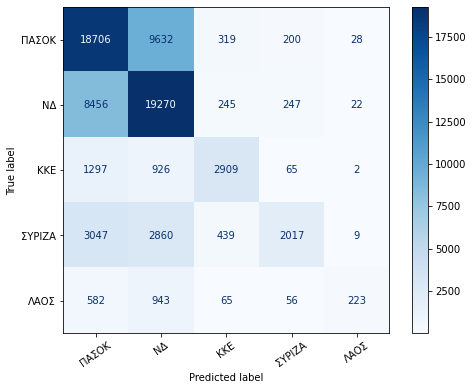

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(sgd_clf, X_test, y_test,
                      display_labels=party_names,
                      cmap=plt.cm.Blues, ax=ax, values_format='g', xticks_rotation=35.50)

#### Grid Search

---
SGDClassifier

Now we will run a **GridSearch**, to find the best parameters of the *SGDClassifier*.

In [ ]:
from sklearn.model_selection import GridSearchCV
sgd_clf_3 = Pipeline([('vect', HashingVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', random_state=42, warm_start=True, n_iter_no_change=4))
                   ])
parameters = {'vect__ngram_range': [(1, 2), (2, 3)],
              'tfidf__use_idf': (True, False),
              'clf__shuffle': (True, False),
              'clf__alpha': (1e-9, 1e-6, 1e-3),
             }
gs_sgd_clf = GridSearchCV(sgd_clf_3, parameters, n_jobs=-1, cv=3)
gs_sgd_clf = gs_sgd_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [ ]:
gs_sgd_clf.best_params_

{'clf__alpha': 1e-06,
 'clf__shuffle': True,
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 2)}

We will use this model, which has the best parameters, from the ones we tested.

In [ ]:
# {'clf__alpha': 1e-06, 'clf__shuffle': True, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
predicted = gs_sgd_clf.predict(X_test)
np.mean(predicted == y_test)
print()

print(metrics.classification_report(y_test, predicted, target_names=party_names))

print()
print(metrics.confusion_matrix(y_test, predicted))


              precision    recall  f1-score   support

       ΠΑΣΟΚ       0.66      0.68      0.67     28885
          ΝΔ       0.64      0.70      0.67     28240
         ΚΚΕ       0.83      0.64      0.72      5199
      ΣΥΡΙΖΑ       0.70      0.56      0.62      8372
        ΛΑΟΣ       0.80      0.41      0.54      1869

    accuracy                           0.66     72565
   macro avg       0.72      0.60      0.65     72565
weighted avg       0.67      0.66      0.66     72565


[[19677  8037   289   808    74]
 [ 7287 19750   197   931    75]
 [  962   677  3327   221    12]
 [ 1676  1766   187  4717    26]
 [  395   571    26   108   769]]


Indeed, the accuracy increased to 0.66 %. and all f1-scores are above 50% percent. Even the class 'ΛΑΟΣ' with only 1869 testing data, achieved 0.8% precision and predicted 766 speeches correctly.

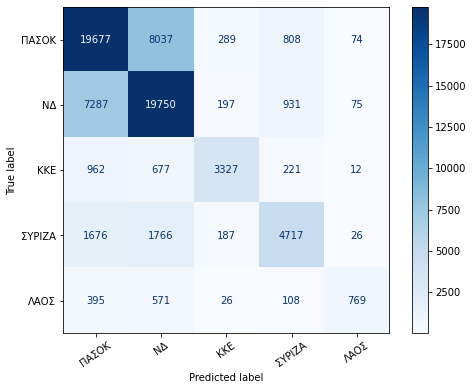

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(gs_sgd_clf, X_test, y_test,
                      display_labels=party_names,
                      cmap=plt.cm.Blues, ax=ax, values_format='g', xticks_rotation=35.50)

#### Naive Bayes

---

In [ ]:
from sklearn.naive_bayes import MultinomialNB

NB_clf = make_pipeline(HashingVectorizer(alternate_sign=False),
                        TfidfTransformer(),
                        MultinomialNB())
NB_clf.fit(X_train, y_train)
predicted = NB_clf.predict(X_test)
print(np.mean(predicted == y_test))
print()

print(metrics.classification_report(y_test, predicted, target_names=party_names))

print()
print(metrics.confusion_matrix(y_test, predicted))

0.5227864673051746

              precision    recall  f1-score   support

       ΠΑΣΟΚ       0.49      0.81      0.61     28885
          ΝΔ       0.58      0.52      0.55     28240
         ΚΚΕ       0.00      0.00      0.00      5199
      ΣΥΡΙΖΑ       0.00      0.00      0.00      8372
        ΛΑΟΣ       0.00      0.00      0.00      1869

    accuracy                           0.52     72565
   macro avg       0.21      0.26      0.23     72565
weighted avg       0.42      0.52      0.46     72565


[[23299  5586     0     0     0]
 [13602 14637     0     1     0]
 [ 4312   887     0     0     0]
 [ 5146  3226     0     0     0]
 [ 1014   855     0     0     0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Naive Bayes seems not be as good as SGDClassfier.

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

The third classifier we are going to test, is the Logistic Regression.


In [ ]:
%%time
lr1_clf = Pipeline([('vect', HashingVectorizer(n_features=2**15)),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(random_state=42, multi_class='multinomial', max_iter=150,
                                               warm_start=True, n_jobs=-1,) )
                  ])
lr1_clf.fit(X_train, y_train)
predicted = lr1_clf.predict(X_test)
print(np.mean(predicted == y_test))
print()

print(metrics.classification_report(y_test, predicted, target_names=party_names))

print()
print(metrics.confusion_matrix(y_test, predicted))

0.6334183146144836

              precision    recall  f1-score   support

       ΠΑΣΟΚ       0.61      0.68      0.64     28885
          ΝΔ       0.62      0.66      0.64     28240
         ΚΚΕ       0.82      0.59      0.68      5199
      ΣΥΡΙΖΑ       0.68      0.48      0.56      8372
        ΛΑΟΣ       0.77      0.33      0.46      1869

    accuracy                           0.63     72565
   macro avg       0.70      0.55      0.60     72565
weighted avg       0.64      0.63      0.63     72565


[[19566  8273   266   728    52]
 [ 8479 18714   184   775    88]
 [ 1182   708  3059   241     9]
 [ 2113  2008   200  4014    37]
 [  482   641    28   107   611]]
CPU times: user 31.2 s, sys: 855 ms, total: 32 s
Wall time: 1min 52s


Logistic Regression works as good as SGD Classifier.

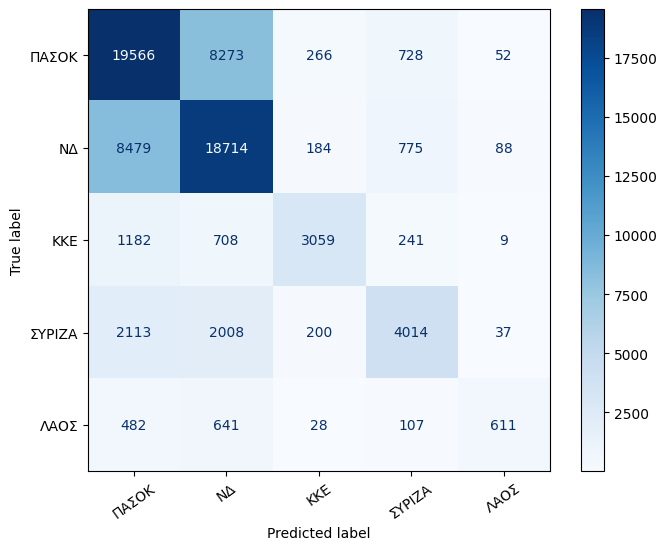

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(lr1_clf, X_test, y_test,
                      display_labels=party_names,
                      cmap=plt.cm.Blues, ax=ax, values_format='g', xticks_rotation=35.50)

We can notice that in all confusion matrices, New Democracy (ΝΔ) confuses speeches of PASOK (ΠΑΣΟΚ), and the opposite.

### Dummy Classifier

We will use a Dummy Classifier to gauge our previosu models.

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = Pipeline([('vect', HashingVectorizer(n_features=2**15)),
                    ('tfidf', TfidfTransformer()),
                    ('clf', DummyClassifier())
                  ])

dummy_clf.fit(X_train, y_train)
predicted = dummy_clf.predict(X_test)
print(np.mean(predicted == y_test))
print()

print(metrics.classification_report(y_test, predicted, target_names=party_names))

print()
print(metrics.confusion_matrix(y_test, predicted))

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning:

The default value of strategy will change from stratified to prior in 0.24.



0.3294012264865982

              precision    recall  f1-score   support

       ΠΑΣΟΚ       0.40      0.40      0.40     28885
          ΝΔ       0.39      0.39      0.39     28240
         ΚΚΕ       0.07      0.07      0.07      5199
      ΣΥΡΙΖΑ       0.11      0.11      0.11      8372
        ΛΑΟΣ       0.03      0.03      0.03      1869

    accuracy                           0.33     72565
   macro avg       0.20      0.20      0.20     72565
weighted avg       0.33      0.33      0.33     72565


[[11522 11370  2004  3236   753]
 [11318 11031  1981  3125   785]
 [ 2061  2033   368   580   157]
 [ 3349  3309   563   929   222]
 [  715   750   127   224    53]]


Scores of Dummy Classifier are very far from those of the other classifiers. That means that previous models work good enough.

### **Neural Network**

We will count the words of our train data, and check the lengths of the speeches.

In [ ]:
from collections import Counter
# Count unique words
def counter_word(text):
  count = Counter()
  for i in text:
    for word in i.split(' '):
      count[word] += 1
  return count
counter = counter_word(X_train)

In [ ]:
max_features = len(counter)
max_features

135859

In [ ]:
# type(counter)
l_5000, l_15000, l_25000, l_35000, l_50000, = 0,0,0,0,0

tl,j, mj, _mj = 0,0,0,0
max, min = -1,9000
max_of_5000=0
for sentence in X_train:
  ls = len(sentence)
  tl += ls
  if  ls > max:
    max = ls
    mj = j
  if ls < min:
    min = ls
    _mj = j

  if ls<=5000:
    l_5000+=1
    max_of_5000 += ls
  elif ls<=15000:
    l_15000 += 1
  elif ls<=25000:
    l_25000 += 1
  elif ls<=35000:
    l_35000 += 1
  else:
    l_50000 += 1

  j+=1

avg_speech_len = tl/len(X_train)
print('Average speech length:',avg_speech_len)
print('Average length under 5000 words:', max_of_5000/l_5000,'\n')

print('Max speech length:', max, '\nMax element:', mj)
print('Min speech length:', min, '\nMin element:', _mj,'\n')

print("%.2f" % (l_5000/len(X_train)), '% --', l_5000)
print("%.2f" % (l_15000/len(X_train)), '% --', l_15000)
print("%.2f" % (l_25000/len(X_train)), '% --', l_25000)
print("%.2f" % (l_35000/len(X_train)), '% --', l_35000)
print("%.2f" % (l_50000/len(X_train)), '% --', l_50000)

Average speech length: 1153.4517855338227
Average length under 5000 words: 994.0012321724475 

Max speech length: 54238 
Max element: 21760
Min speech length: 26 
Min element: 180497 

0.97 % -- 211821
0.03 % -- 5829
0.00 % -- 42
0.00 % -- 1
0.00 % -- 1


* 0.97% of the speeches were shorter thank 5000 characters.
* 0.03 had less than 15000 and more than 5000
* Almost zero percent had more than 15000 words

**NOTE**: If you want to execute on TPU (instead of GPU or CPU), uncomment the next cell and run it. Otherwise, ignore it.

#### TPU

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
#   print("Running on TPU ", tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.10.121.82:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.10.121.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.121.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


#### Word embeddings

To begin, we must transform our data to word embeddings, for better results and performance of the model.

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers

from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D

We start by tokenizing the train dataset (integer-encoding).

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
%%time
tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

CPU times: user 55.7 s, sys: 82 ms, total: 55.8 s
Wall time: 56.2 s


* Now we pad, in order all of our sequences, to have the same length.
* We want all of our sequences, to be filled with 0 from right (end) to the left (start). That's why we choose 'post' for the **padding** parameter.
* We will specify THE maximum length, as the average speech length (which we found earlier), because the longest word is 54238, and 93% of speeches have less than 5000 words, so it would ruin the sequences.
* We will truncate sequences with more than average length, from the end of the sequence, to the beggining.

In [ ]:
%%time
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(
  train_sequences, padding="post", maxlen=int(avg_speech_len), truncating='post'
)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(
  test_sequences, padding="post", maxlen=int(avg_speech_len), truncating='post'
)

CPU times: user 1min 4s, sys: 515 ms, total: 1min 4s
Wall time: 1min 5s


#### Running our model

At modelling:
* We set `mask_zero` to 0, so that the model understands the *zeros* as **padding** values.
* We use *softmax* as activation method, because our labels are provided as integers.

At compile:
* In optimizer, we 've set a decreasing learning rate over time, to improve the weights (but at the cost of the execution time).

In [ ]:
embedding_dim=100
lr = tf.keras.optimizers.schedules.InverseTimeDecay(0.1, 1.0, 0.5)

def modelling():
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=train_padded.shape[1],  mask_zero=0, name='Embedding'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(embedding_dim, activation='relu', name='RELU'),
      tf.keras.layers.Dense(5, activation='softmax', name='Softmax'),
  ])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=tf.keras.metrics.SparseCategoricalAccuracy()
  )
  return model

# NOTE: If you DO want to run on TPU, uncomment the next line and create model INSIDE the next block. Otherwise, ignore next line.
# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model = modelling()

* EarlyStopping will stop the fitting, if there is no progress for 10 consecutive epochs (propably there will be no need to continue).

In [ ]:
model.summary()

num_epochs = 100
early_stopping = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True),
]
 
history = model.fit(
    train_padded, y_train,
    callbacks=[early_stopping],
    validation_split = 0.2,
    epochs=num_epochs
  )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 1153, 100)         13585900  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1153, 100)         0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
RELU (Dense)                 (None, 100)               10100     
_________________________________________________________________
Softmax (Dense)              (None, 5)                 505       
Total params: 13,596,505
Trainable params: 13,596,505
Non-trainable params: 0
__________________________________________

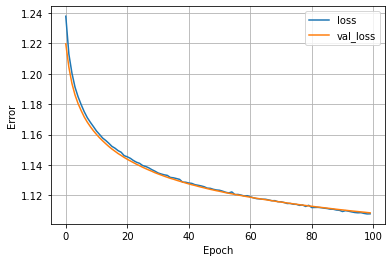

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

Our learning curves show us that the fitting was good, and we could give even more epochs, without leading to over-fit. We understand this because:
1. Both plots are decreasing to a point, that seems like they are going to stabilize later on(if we had given more epochs), and
2. most of the times, if we notice their route from 0 to 100 epochs, there is a small gap between the two plots.

At this point, the session **crashed** (because of a wrong execution), the evaluation of the model did not complete, and I did not have enough time to re-run the model. As a result, the reader will have to run and discover by himself the evaluation.

In [ ]:
model.evaluate(test_padded, y_test, verbose=1)